In [1]:
#Imports

import numpy as np
import torch
from torchvision import datasets, transforms
from torch import nn

In [2]:
# Make a folder for saving model state

!mkdir save

In [3]:
#The CNN Model

class CNN(nn.Module):
  def __init__(self, lr=0.01, outputSize=100):
    super().__init__()
    self.CNN = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size = 3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size = 3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(43264, 10000),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(10000, 5000),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(5000, outputSize)
    )

    self.lr = lr

  def forward(self, X):
    return self.CNN(X)

  def loss(self, y_hat, y):
    fn = nn.CrossEntropyLoss()
    return fn(y_hat, y)

  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters())

In [5]:
class Trainer:
  def __init__(self):
    return

  def fit_epoch(self): #Single epoch

    #Data for monitoring preformance
    current_lossT = []
    current_lossV = []

    for i, data in enumerate(self.dataT): #Triaing
        inputs, target = data
        inputs = inputs.to(device)#Send to gpu
        target = target.to(device)

        inputs = inputs.to(torch.float32)
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.model.loss(outputs, target)
        #Update model
        loss.backward()
        self.optimizer.step()

        current_lossT.append(loss.item())#Store loss

    for i, data in enumerate(self.dataV): #Validation
        inputs, target = data
        inputs = inputs.to(device)#Send to gpu
        target = target.to(device)
        inputs = inputs.to(torch.float32)
        outputs = self.model(inputs)
        loss = self.model.loss(outputs, target)

        current_lossV.append(loss.item())#Store loss

    #Return average loss for monitoring
    return sum(current_lossT) / len(current_lossT), sum(current_lossV) / len(current_lossV)



  def fit(self, model, dataT, dataV, path=None):#Trains till validation drops
    self.model     = model

    if path != None: #Continue models training
      self.model.load_state_dict(torch.load(path, weights_only=True))

    self.dataT = dataT
    self.dataV = dataV

    self.optimizer = model.configure_optimizers()#Optimizer

    #Tracking loss and Epoch count
    EpochCount = 0
    TLoss = []
    VLoss = []

    flag = True
    Best = float('inf')

    while flag == True:#Flag true when epoches less then max and validation on the fall
      tempT, tempV = self.fit_epoch()
      TLoss.append(tempT)
      VLoss.append(tempV)

      if EpochCount+1 >= 10: #max epochs
        flag = False
      if EpochCount>2: #Stop on Validation as indicator of generalization
        if VLoss[EpochCount] > VLoss[EpochCount-1] and VLoss[EpochCount-1] > VLoss[EpochCount-2] and VLoss[EpochCount-2] > VLoss[EpochCount-3]:
          flag = False

      print("epoch: " + str(EpochCount+1) + " ValLoss: " + str(VLoss[EpochCount]))


      #Save best model and latest model
      if tempV < Best:
        print("Lowest loss yet!!")
        Best = tempV
        torch.save(self.model.state_dict(), "/content/save/best")

      torch.save(self.model.state_dict(), "/content/save/last")
      EpochCount +=1
    return TLoss, VLoss

In [27]:

class Tester:#Prints test outcomes

  def __init__(self):
    return

  def Test(self, model, data, load):
      self.model = model
      self.dataT = data
      self.model.load_state_dict(torch.load(load, weights_only=True))#load instance of model

      right = 0
      wrong = 0

      for i, data in enumerate(self.dataT):
          inputs, target = data
          inputs = inputs.to(device)#send to gpu
          target = target.to(device)
          inputs = inputs.to(torch.float32)
          outputs = self.model(inputs)

          indices = torch.max(outputs, 1).indices
          outputs = outputs.cpu().detach().numpy()

          #Tally hits and misses
          if indices==target:
            right+=1
          else:
            wrong+=1



      total = 0
      accuracy = right / (right + wrong)
      print("accuracy: " + str(accuracy))

      #The following can be uncommented if the results on a class basis are needed
      #for c in range(100):
        #print("class: " + str(c) + "Accuracy: " + str((classes_right[c]/50)*100))

In [7]:
#Dataset
train = datasets.CIFAR100('./data/', train=True, download=True, transform=transforms.ToTensor())
temp = datasets.CIFAR100('./data/', train=False, download=True, transform=transforms.ToTensor())

#Split is (Train : 500 (83.3%)) (Validate : 50 (8.3%)) (Test : 50 (8.3%)) for each class
test = []
validate = []
array = np.zeros(100)

for data in temp:
  if array[data[1]] < 50:
    test.append(data)
    array[data[1]] += 1
  else:
    validate.append(data)

#Final datasets
dl_train = torch.utils.data.DataLoader(dataset=train, batch_size=10, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=test, batch_size=1, shuffle=True)
dl_validate = torch.utils.data.DataLoader(dataset=validate, batch_size=1, shuffle=True)

100%|██████████| 169M/169M [00:03<00:00, 48.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified


In [11]:
#Creates and trains Model

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp_model = CNN(lr=0.01).to(device)
trainer = Trainer()


#Create new Model
TLoss, VLoss = trainer.fit(mlp_model, dl_train, dl_validate)

#Or load Model to continue training
#TLoss, VLoss = trainer.fit(mlp_model, dl_train, dl_validate, "example_path")

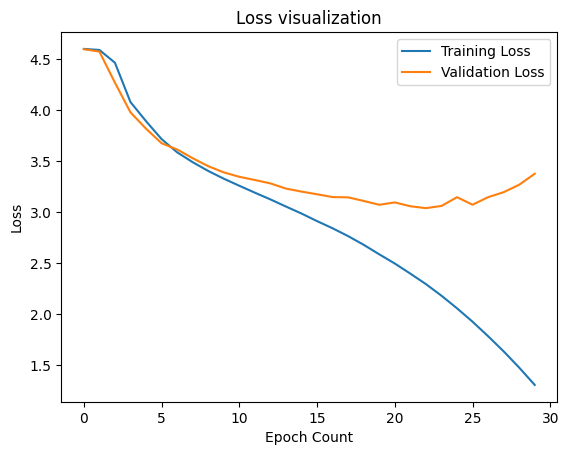

In [6]:
#Ploting loss
import matplotlib.pyplot as plt

plt.plot(TLoss, label = "Training Loss")
plt.plot(VLoss, label = "Validation Loss")
plt.title("Loss visualization")
plt.xlabel("Epoch Count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
#Tests Model on unseen data

#Data presentation can be configured in the Tester Class

Tester = Tester()

Tester.Test(mlp_model, dl_test, "/content/save/d")

accuracy: 0.2884
rd = 17.44098900062201
wd = 14.401997582975433
